In [ ]:
from IPython import get_ipython
from IPython.display import display

In [ ]:
from google.colab import drive
import os
import shutil

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
# Path to the Google Drive folder containing images
cat_dog_pred = '/content/drive/MyDrive/cat dog'

In [ ]:
cat_folder = 'cats'
dog_folder = 'dogs'

# Define the paths to the corresponding folders in Colab
cat_dog = '/content/images/cat dog'
cat_colab_folder = os.path.join(cat_dog_pred, cat_folder)
dog_colab_folder = os.path.join(cat_dog_pred, dog_folder)

# Create the base destination directory in Colab
os.makedirs(cat_dog, exist_ok=True) # This line is added to create the base directory

# Create destination folders in Colab if they don't exist
os.makedirs(cat_colab_folder, exist_ok=True)
os.makedirs(dog_colab_folder, exist_ok=True)

# Copy files from Google Drive to Colab for each folder
for folder_name in [cat_folder, dog_folder]:
    source_folder_path = os.path.join(cat_dog_pred, folder_name)
    destination_folder_path = os.path.join(cat_dog, folder_name) # This line now uses the correct cat_dog path

    # Create the destination folder if it doesn't exist
    os.makedirs(destination_folder_path, exist_ok=True)  # This line ensures the destination folder exists

    # List files in the source folder
    folder_files = os.listdir(source_folder_path)

    # Copy files from source folder to destination folder
    for file_name in folder_files:  # Iterate through files in the source folder
        source_file_path = os.path.join(source_folder_path, file_name)
        destination_file_path = os.path.join(destination_folder_path, file_name)

        # Check if it's a file and copy
        if os.path.isfile(source_file_path):
            shutil.copyfile(source_file_path, destination_file_path)

print("Images downloaded successfully!")

Images downloaded successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
EPOCHS=10
CHANNELS=3



In [ ]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    '/content/images/cat dog',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE,
)

Found 555 files belonging to 2 classes.


In [ ]:
class_names= dataset.class_names
class_names

['cats', 'dogs']

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1]


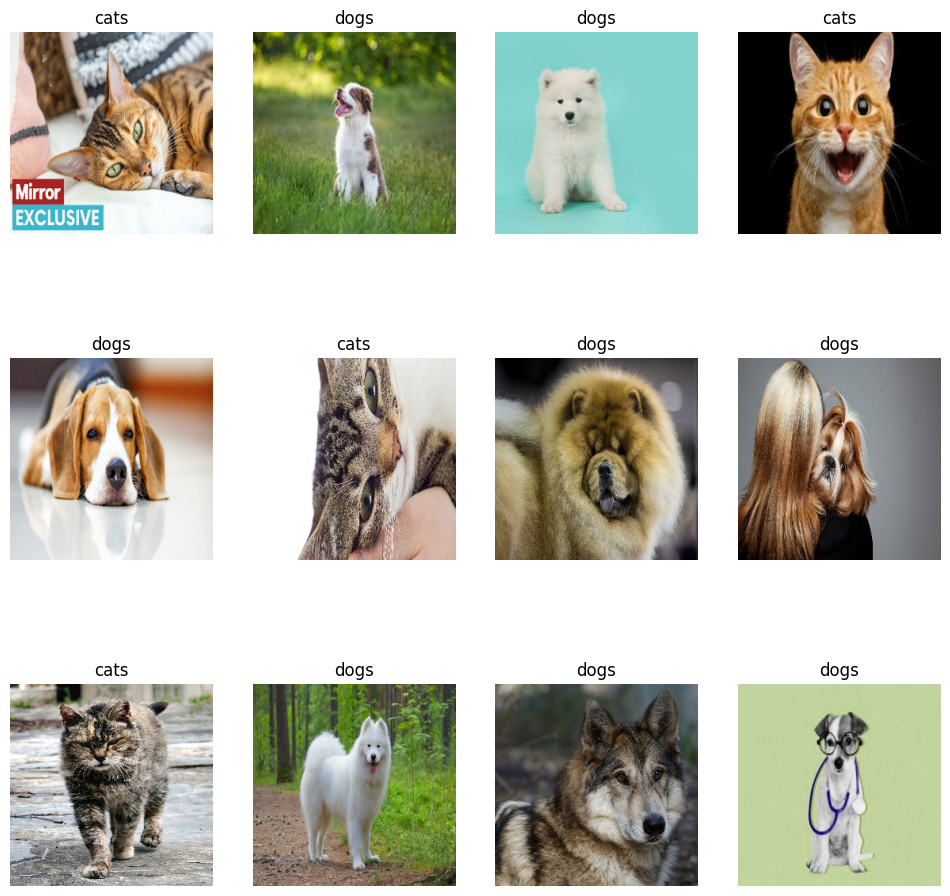

In [ ]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax= plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [ ]:
train_size = 0.8
len(dataset)*train_size

14.4

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (256, 256, 3)
n_classes = 2

cnn = models.Sequential([
    # resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# cnn.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,682 (717.51 KB)

 Trainable params: 183,682 (717.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = cnn.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

'history = cnn.fit(\n    train_ds,\n    batch_size=BATCH_SIZE,\n    validation_data=val_ds,\n    verbose=1,\n    epochs=EPOCHS,\n)'

In [ ]:
# prompt: train the data using vgg16

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model (excluding the top classification layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze the layers of the base model to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)  # You can adjust the number of units
predictions = Dense(n_classes, activation='softmax')(x)

# Create the new model
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
vgg16_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Print the model summary
vgg16_model.summary()

# Train the model
history = vgg16_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 23,104,066 (88.14 MB)

 Trainable params: 8,389,378 (32.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5891 - loss: 46.9864 - val_accuracy: 0.9062 - val_loss: 2.5879
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step - accuracy: 0.8175 - loss: 2.8929 - val_accuracy: 0.9688 - val_loss: 0.1045
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8843 - loss: 1.1024 - val_accuracy: 0.9688 - val_loss: 0.5147
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 432ms/step - accuracy: 0.8719 - loss: 1.5382 - val_accuracy: 0.9688 - val_loss: 0.0302
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.8747 - loss: 1.1093 - val_accuracy: 0.9688 - val_loss: 0.0858
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.9012 - loss: 0.7872 - val_accuracy: 1.0000 - val_loss: 5.8742e-06
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - accuracy: 0.9239 - loss: 0.4736 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step - accuracy: 0.9255 - loss: 0.6791 - val_accuracy

Saving download (10).jpg to download (10).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction for download (10).jpg: dogs


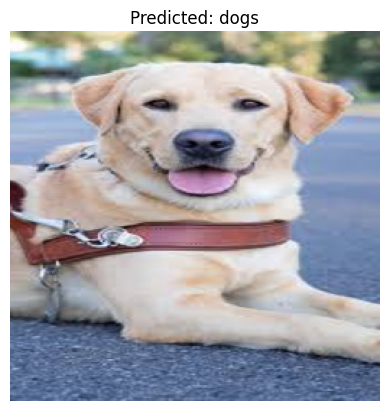

In [ ]:
# prompt: upload file from files predict the file using trained data and plot the image too

import numpy as np
from google.colab import files
from PIL import Image

uploaded = files.upload()

for fn in uploaded.keys():
  # Predict the image
  img = Image.open(fn).convert('RGB').resize((256,256)) # Ensure image is RGB and resized
  img_array = np.array(img) / 255.0  # Normalize pixel values
  img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
  prediction = vgg16_model.predict(img_array)
  predicted_class = np.argmax(prediction)

  # Print prediction
  print(f"Prediction for {fn}: {class_names[predicted_class]}")

  # Display the image
  plt.imshow(img)
  plt.title(f"Predicted: {class_names[predicted_class]}")
  plt.axis('off')
  plt.show()

Saving VIER PFOTEN_2020-10-07_00138-2890x2000-1920x1329.jpg to VIER PFOTEN_2020-10-07_00138-2890x2000-1920x1329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction for VIER PFOTEN_2020-10-07_00138-2890x2000-1920x1329.jpg: cats


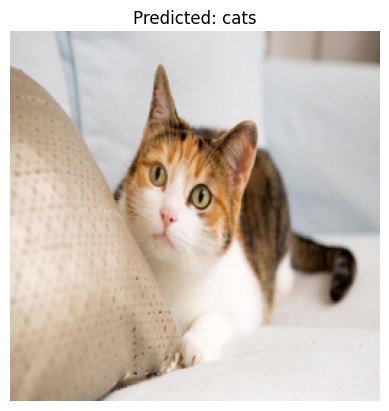

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Assuming 'vgg16_model' and 'class_names' are defined from the previous code

uploaded = files.upload()

for fn in uploaded.keys():
  # Predict the image
  try:
    img = Image.open(fn).convert('RGB').resize((256,256)) # Ensure image is RGB and resized
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    prediction = vgg16_model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Print prediction
    print(f"Prediction for {fn}: {class_names[predicted_class]}")

    # Display the image
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.axis('off')
    plt.show()
  except Exception as e:
    print(f"Error processing {fn}: {e}")

Saving images (1).jpg to images (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction for images (1).jpg: cats


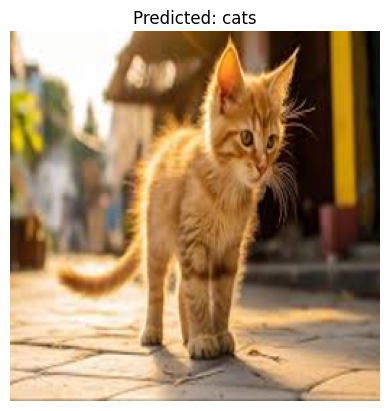

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Assuming 'vgg16_model' and 'class_names' are defined from the previous code

uploaded = files.upload()

for fn in uploaded.keys():
  # Predict the image
  try:
    img = Image.open(fn).convert('RGB').resize((256,256)) # Ensure image is RGB and resized
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    prediction = vgg16_model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Print prediction
    print(f"Prediction for {fn}: {class_names[predicted_class]}")

    # Display the image
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.axis('off')
    plt.show()
  except Exception as e:
    print(f"Error processing {fn}: {e}")